# Homework Assignment  6

## Q1

**Question 1:** Construct a sentiment classifier using 80% of the reviews in the [Amazon Fine Food Reviews dataset](https://www.kaggle.com/snap/amazon-fine-food-reviews).
The classifier needs to predict if a product got a one-star or a five-star review. 
Evaluate the classifier using the rest of the data (30pt). 


### Preperations:

In [ ]:
!pip install turicreate
!pip install kaggle 
!pip install gensim
!pip install pyLDAvis
!pip install spaCy
!pip install afinn
! pip install textblob

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json 
! mkdir -f ./datasets/amazon_reviews

!kaggle datasets download snap/amazon-fine-food-reviews  -p ./datasets/amazon_reviews
!unzip ./datasets/amazon_reviews/*.zip  -d ./datasets/amazon_reviews

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: invalid option -- 'f'
Try 'mkdir --help' for more information.
 97% 235M/242M [00:04<00:00, 69.7MB/s]
100% 242M/242M [00:04<00:00, 52.6MB/s]
Archive:  ./datasets/amazon_reviews/amazon-fine-food-reviews.zip
  inflating: ./datasets/amazon_reviews/Reviews.csv  
  inflating: ./datasets/amazon_reviews/database.sqlite  
  inflating: ./datasets/amazon_reviews/hashes.txt  


In [ ]:
# IMPORTS
import os
import json
import re
import requests
from typing import *
import numpy as np
import pandas as pd
import turicreate as turi
import networkx as ntkx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 

%matplotlib inline

In [ ]:
reviews_sframe = turi.SFrame.read_csv('/content/datasets/amazon_reviews/Reviews.csv')
# taking a subset (~1/3) of the reviews (to reduce runtime)
reviews_sframe = reviews_sframe[:100000]

### Q1 ans:

In [ ]:
# creating the features sframe from the review text field
reviews_features_sframe = turi.SFrame()
# removing all stop words as they are usually not very informative
reviews_features_sframe['text_words_1grams'] = turi.text_analytics.count_ngrams(reviews_sframe['Text'], n=1, method='word').dict_trim_by_keys(turi.text_analytics.stop_words(), True)
reviews_features_sframe['summary_words_1grams'] = turi.text_analytics.count_ngrams(reviews_sframe['Summary'], n=1, method='word').dict_trim_by_keys(turi.text_analytics.stop_words(), True)
reviews_features_sframe['text_words_2grams'] = turi.text_analytics.count_ngrams(reviews_sframe['Text'], n=2, method='word').dict_trim_by_keys(turi.text_analytics.stop_words(), True)
reviews_features_sframe['summary_words_2grams'] = turi.text_analytics.count_ngrams(reviews_sframe['Summary'], n=2, method='word').dict_trim_by_keys(turi.text_analytics.stop_words(), True)

reviews_features_sframe['helpfulness_score'] = np.divide(reviews_sframe['HelpfulnessNumerator'].to_numpy(), reviews_sframe['HelpfulnessDenominator'].to_numpy(), where=reviews_sframe['HelpfulnessDenominator'].to_numpy()!=0) 
# i created a classifier that predicts the score from 1 to 5 (not only 1 OR 5).
reviews_features_sframe['class'] = reviews_sframe['Score']
reviews_features_sframe

text_words_1grams,summary_words_1grams,text_words_2grams,summary_words_2grams
"{'appreciates': 1,'labrador': 1, 'smells': ...","{'food': 1, 'dog': 1,'quality': 1, 'good': 1} ...","{'more like': 1, 'foodproducts': 1, 'a stew': ...","{'dog food': 1, 'qualitydog': 1, 'good quality': ..."
"{'intended': 1, 'salted':1, 'product': 2, ...",{'advertised': 1},"{'the product': 1,'represent the': 1, 'to ...","{'as advertised': 1, 'notas': 1} ..."
"{'sisters': 1, 'brother':1, 'selling': 1, ...",{'delight': 1},"{'to the': 1, 'brotherand': 1, 'out his': 1, ...","{'it all': 1, 'says it':1, 'delight says': 1} ..."
"{'medicinal': 1,'flavor': 1, 'soda': 1, ...","{'medicine': 1, 'cough':1} ...","{'is very': 1, 'sodathe': 1, 'cherry soda': ...",{'cough medicine': 1}
"{'deal': 1, 'lover': 1,'quick': 1, 'delivery': ...","{'taffy': 1, 'great': 1}","{'lover this': 1, 'awide': 1, 'a deal': 1, ...",{'great taffy': 1}
"{'treat': 1,'delightful': 1, ...","{'taffy': 1, 'nice': 1}","{'delightful treat': 1,'recommend this': 1, ...",{'nice taffy': 1}
"{'themed': 1, 'served':1, 'beach': 1, ...","{'brands': 1,'expensive': 1, 'good': ...","{'loved it': 1, 'everyoneloved': 1, 'and ...","{'expensive brands': 1,'good as': 1, 'the ..."
"{'recommend': 1,'amazing': 1, ...","{'tasty': 1, 'taffy': 1,'wonderful': 1} ...","{'and chewy': 1, 'verysatisfying': 1, 'this ...","{'tasty taffy': 1,'wonderful tasty': 1} ..."
"{'rye': 1, 'cats': 1,'eat': 1, 'sprouting' ...","{'barley': 1, 'yay': 1}","{'rye too': 1, 'and rye':1, 'with wheatgrass': 1, ...",{'yay barley': 1}
"{'feeding': 1,'required': 1, 'eats' ...","{'food': 1, 'dog': 1,'healthy': 1} ...","{'every feeding': 1,'their digestion': 1, ...","{'dog food': 1, 'healthydog': 1} ..."


In [ ]:
train, test = reviews_features_sframe.random_split(0.8)
cls = turi.classifier.create(train,features=['text_words_1grams', 'summary_words_1grams', 'text_words_2grams', 'summary_words_2grams', 'helpfulness_score'], target="class", verbose=True)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 75981

Number of classes           : 5

Number of feature columns   : 5

Number of unpacked features : 1030052

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 4.823338     | 0.665969          | 0.669250            | 1.358076          | 1.354577            |

| 2         | 9.608004     | 0.667140          | 0.671250            | 1.220932          | 1.217350            |

| 3         | 14.395061    | 0.668680          | 0.671000            | 1.134880          | 1.131284            |

| 4         | 19.286093    | 0.669654          | 0.671000            | 1.075041          | 1.073639            |

| 5         | 24.174419    | 0.673432          | 0.674000            | 1.026955          | 1.026783            |

| 7         | 33.958843    | 0.677709          | 0.675750            | 0.969464          | 0.973709            |

| 8         | 38.860251    | 0.679933          | 0.677250            | 0.947957          | 0.954122            |

| 9         | 43.775628    | 0.681710          | 0.677500            | 0.929882          | 0.939693            |

| 10        | 48.719187    | 0.685803          | 0.680250            | 0.914098          | 0.926321            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 75981

Number of classes           : 5

Number of feature columns   : 5

Number of unpacked features : 1030052

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 4.156014     | 0.664600          | 0.664750            | 1.043350          | 1.038440            |

| 2         | 8.087143     | 0.664561          | 0.668000            | 1.037622          | 1.030635            |

| 3         | 11.992962    | 0.662705          | 0.664250            | 1.034108          | 1.028381            |

| 4         | 15.952579    | 0.660810          | 0.662250            | 1.034179          | 1.028922            |

| 5         | 19.858459    | 0.660836          | 0.662750            | 1.033396          | 1.027591            |

| 7         | 27.773149    | 0.660441          | 0.663000            | 1.033062          | 1.026539            |

| 8         | 31.707643    | 0.660691          | 0.663500            | 1.032592          | 1.026042            |

| 9         | 35.666543    | 0.661402          | 0.663750            | 1.032363          | 1.025791            |

| 10        | 39.549655    | 0.661639          | 0.663250            | 1.032273          | 1.025737            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 75981

Number of classes           : 5

Number of feature columns   : 5

Number of unpacked features : 1030052

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 4.754825     | 0.665969          | 0.669250            | 1.038352          | 1.029982            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 75981

Number of classes           : 5

Number of feature columns   : 5

Number of unpacked features : 1030052

Number of coefficients      : 4120212

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 4        | 0.250000  | 3.537844     | 0.637212          | 0.640500            |

| 1         | 7        | 1.250000  | 268.811151   | 0.838881          | 0.672750            |

| 2         | 8        | 1.250000  | 539.823623   | 0.970361          | 0.711000            |

| 3         | 9        | 1.250000  | 809.696862   | 0.990787          | 0.736250            |

| 4         | 10       | 1.250000  | 1080.273020  | 0.997828          | 0.756500            |

| 6         | 12       | 1.250000  | 1626.488266  | 0.999526          | 0.763500            |

| 7         | 13       | 1.250000  | 1901.448278  | 0.999750          | 0.764500            |

| 8         | 14       | 1.250000  | 2175.743852  | 0.999789          | 0.765500            |

| 9         | 15       | 1.250000  | 2449.698775  | 0.999895          | 0.767250            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.68025
PROGRESS: RandomForestClassifier          : 0.66325
PROGRESS: DecisionTreeClassifier          : 0.66925
PROGRESS: LogisticClassifier              : 0.76725
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


In [ ]:
# evaluating the classifier
cls_eval_results = cls.evaluate(test)

cls_summary_dict = cls.summary('dict')
classifier_algorithm = ''.join([x for x in str(type(cls)).split('.')[-1] if x.isalpha()])
test_f1_score, test_size = cls_eval_results['f1_score'], len(test)
# validation_score = dict(cls_summary_dict['sections'][1])['Validation accuracy']

## Q2

**Question 2:** Construct a sentiment classifier using features from the [TextBlob package](https://textblob.readthedocs.io/en/dev/index.html),
    and from the [affin package](https://pypi.org/project/afinn/). Compare the two classifiers results and visualize it (however you want) (20pt)

### Preperations:

In [ ]:
! pip install turicreate
! pip install kaggle 
! pip install gensim
! pip install pyLDAvis
! pip install spaCy
! pip install afinn
! pip install textblob

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json 
! mkdir -f ./datasets/amazon_reviews

! kaggle datasets download snap/amazon-fine-food-reviews  -p ./datasets/amazon_reviews
! unzip ./datasets/amazon_reviews/*.zip  -d ./datasets/amazon_reviews

In [ ]:
# IMPORTS
import os
import json
import re
import requests
from typing import *
import numpy as np
import pandas as pd
import turicreate as turi
import networkx as ntkx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from textblob import TextBlob
from afinn import Afinn


%matplotlib inline

In [ ]:
org_reviews_sframe = turi.SFrame.read_csv('/content/datasets/amazon_reviews/Reviews.csv')
org_reviews_sframe = org_reviews_sframe[:100000]

Unexpected characters after last column. "B000GW46D4"
Parse failed at token ending at: 
	myself that tastes much better than this."
35360,B000GW46D4,^A1DPWQR4WSPXTM,Japri,0,0,2,1331424000,Very unsat
Successfully parsed 10 tokens: 
	0: 35359
	1: B000GW46D4
	2: A2Y4S4CNGKF21S
	3: H. Swanson
	4: 0
	5: 0
	6: 2
	7: 1332374400
	8: Very dry,  ... rumbly :",
	9: to the poi ... is."
35360

Unexpected characters after last column. "one of only a very few"
Parse failed at token ending at: 
	hile. This is a very rare hot sauce, one of only a very few,^ where the actual chile is the major ingredient.
Successfully parsed 10 tokens: 
	0: 74275
	1: B005B3HKPO
	2: A3OC6M21K4UAQ
	3: tw
	4: 2
	5: 5
	6: 2
	7: 1328486400
	8: whats with ... is smell??
	9: ummm can s ... mmended!.,

Unexpected characters after last column. "B000PMJLJO"
Parse failed at token ending at: 
	myself that tastes much better than this."
88623,B000PMJLJO,^A1DPWQR4WSPXTM,Japri,0,0,2,1331424000,Very unsat
Successfully parsed 10 tokens: 
	0: 88622
	1: B000PMJLJO
	2: A2Y4S4CNGKF21S
	3: H. Swanson
	4: 0
	5: 0
	6: 2
	7: 1332374400
	8: Very dry,  ... rumbly :",
	9: to the poi ... is."
88623

3 lines failed to parse correctly

Finished parsing file /content/datasets/amazon_reviews/Reviews.csv

Parsing completed. Parsed 100 lines in 0.658359 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,str,int,int,int,int,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Unexpected characters after last column. "B000GW46D4"
Parse failed at token ending at: 
	myself that tastes much better than this."
35360,B000GW46D4,^A1DPWQR4WSPXTM,Japri,0,0,2,1331424000,Very unsat
Successfully parsed 10 tokens: 
	0: 35359
	1: B000GW46D4
	2: A2Y4S4CNGKF21S
	3: H. Swanson
	4: 0
	5: 0
	6: 2
	7: 1332374400
	8: "Very dry, ... edibly dry
	9: to the poi ... is."
35360

Unexpected characters after last column. "one of only a very few"
Parse failed at token ending at: 
	hile. This is a very rare hot sauce, one of only a very few,^ where the actual chile is the major ingredient.
Successfully parsed 10 tokens: 
	0: 74275
	1: B005B3HKPO
	2: A3OC6M21K4UAQ
	3: tw
	4: 2
	5: 5
	6: 2
	7: 1328486400
	8: whats with ... is smell??
	9: "ummm can  ...  hot sauce

Unexpected characters after last column. "B000PMJLJO"
Parse failed at token ending at: 
	myself that tastes much better than this."
88623,B000PMJLJO,^A1DPWQR4WSPXTM,Japri,0,0,2,1331424000,Very unsat
Successfully parsed 10 tokens: 
	0: 88622
	1: B000PMJLJO
	2: A2Y4S4CNGKF21S
	3: H. Swanson
	4: 0
	5: 0
	6: 2
	7: 1332374400
	8: "Very dry, ... edibly dry
	9: to the poi ... is."
88623

Unexpected characters after last column. "but that awful after taste has no place in my afternoons.  Fog Chaser is flavorful but smooth. If you have had difficulty finding a good coffee for the new machines"
Parse failed at token ending at: 
	e had difficulty finding a good coffee for the new machines,^ do give this one a try."
181216,B007Y59HVM,#oc-
Successfully parsed 10 tokens: 
	0: 181213
	1: B007Y59HVM
	2: #oc-R3W5DW4JKJT228
	3: Mamaw
	4: 0
	5: 2
	6: 1
	7: 1346112000
	8: Disappointed
	9: "I regret  ... he morning

Read 71440 lines. Lines per second: 78753

Unexpected characters after last column. "0"
Parse failed at token ending at: 
	 />\"
190510,B0012UEHFQ,A2788LGTSGCFA6,"Mom of 3 ""sue""",0,^0,5,1329436800,She Loves Them!,I have a crazy do
Successfully parsed 10 tokens: 
	0: 190509
	1: B0012UEHFQ
	2: A3CR0UBHFX0NE7
	3: Sharee Lee Peterson
	4: 0
	5: 0
	6: 1
	7: 1330300800
	8: Poor Substitute
	9: I had prev ... of 3 "sue"

Unable to interpret "encouraged him to eat" as a integer
Parse failed at token ending at: 
	encouraged him to eat,^ again.  It is also low in fat which is what he 
Successfully parsed 0 tokens:

Unable to interpret "aDent just for grins and really like it! The taste is pleasant and long lasting. Nice flavor still after chewing away. Would recommend it to those who aren't sure if it's a product they would like. Great gum product." as a integer
Parse failed at token ending at: 
	aDent just for grins and really like it! The taste is pleasant and long lasting. Nice flavor still after chewing away. Would recommend it to those who aren't sure if it's a product they would like. Great gum product.^
Successfully parsed 0 tokens:

Unexpected characters after last column. "B000GW6786"
Parse failed at token ending at: 
	yself that tastes much better than this."
415822,B000GW6786,^A1DPWQR4WSPXTM,Japri,0,0,2,1331424000,Very unsat
Successfully parsed 10 tokens: 
	0: 415821
	1: B000GW6786
	2: A2Y4S4CNGKF21S
	3: H. Swanson
	4: 0
	5: 0
	6: 2
	7: 1332374400
	8: "Very dry, ... edibly dry
	9: to the poi ... s."
415822

Unable to interpret "no carbonation.  Great for dieters who don't want the calories but are sick of the flavor of water.  The Cherry mint ha a nice flavor with a hint of cherry.  Delicious."
514288" as a integer
Parse failed at token ending at: 
	ha a nice flavor with a hint of cherry.  Delicious."
514288,^B0081X097M,A1YN5RSMH6TTZP,ltgr;blu,0,0,5,1332979
Successfully parsed 4 tokens: 
	0: 514285
	1: B0081X097M
	2: ATO7WKMVJD6XQ
	3: "Curcio "" ... tives.Plus

9 lines failed to parse correctly

Finished parsing file /content/datasets/amazon_reviews/Reviews.csv

Parsing completed. Parsed 289205 lines in 2.35419 secs.

### Q2 ans:

In [ ]:
# we will extract the following features using textblob:
# Counter of nouns in review's text & summary
# sentiment polarity in review's text & summary
# sentiment subjectivity in review's text & summary
# and the following features using affin:
# Afinn sentiment score for review's text & summary

# creating the features sframe from the review text & summary fields
reviews_textblob_and_afinn_features_sframe = turi.SFrame()
features_list = [
                 'TextBlob text polarity', 
                 'TextBlob text subjectivity', 
                 'TextBlob summary polarity', 
                 'TextBlob summary subjectivity', 
                 'Afinn text score', 
                 'Afinn summary score'
                 ]
# TextBlob features
reviews_textblob_and_afinn_features_sframe['TextBlob text polarity'] = org_reviews_sframe['Text'].apply(lambda review: TextBlob(review).sentiment.polarity)
reviews_textblob_and_afinn_features_sframe['TextBlob text subjectivity'] = org_reviews_sframe['Text'].apply(lambda review: TextBlob(review).sentiment.subjectivity)
reviews_textblob_and_afinn_features_sframe['TextBlob summary polarity'] = org_reviews_sframe['Summary'].apply(lambda review: TextBlob(review).sentiment.polarity)
reviews_textblob_and_afinn_features_sframe['TextBlob summary subjectivity'] = org_reviews_sframe['Summary'].apply(lambda review: TextBlob(review).sentiment.subjectivity)
# Afinn features
afinn = Afinn()
reviews_textblob_and_afinn_features_sframe['Afinn text score'] = org_reviews_sframe['Text'].apply(lambda t: afinn.score(t))
reviews_textblob_and_afinn_features_sframe['Afinn summary score'] = org_reviews_sframe['Summary'].apply(lambda t: afinn.score(t))


# i created a classifier that predicts the score from 1 to 5 (not only 1 OR 5).
reviews_textblob_and_afinn_features_sframe['class'] = org_reviews_sframe['Score']

In [ ]:
train, test = reviews_textblob_and_afinn_features_sframe.random_split(0.8)
cls_with_sentiment_analysis_features = turi.classifier.create(train,features=features_list, target="class", verbose=True)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 75656

Number of classes           : 5

Number of feature columns   : 6

Number of unpacked features : 6

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.199567     | 0.676576          | 0.680562            | 1.327490          | 1.325619            |

| 2         | 0.404590     | 0.677316          | 0.682320            | 1.181352          | 1.179425            |

| 3         | 0.626265     | 0.678347          | 0.684078            | 1.090829          | 1.088471            |

| 4         | 0.831354     | 0.678889          | 0.685334            | 1.031079          | 1.029176            |

| 5         | 1.035189     | 0.679801          | 0.686590            | 0.988941          | 0.987706            |

| 10        | 2.093096     | 0.683184          | 0.688348            | 0.899385          | 0.902719            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 75656

Number of classes           : 5

Number of feature columns   : 6

Number of unpacked features : 6

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.190497     | 0.672994          | 0.677800            | 0.989832          | 0.978991            |

| 2         | 0.364228     | 0.673945          | 0.678805            | 0.984771          | 0.975677            |

| 3         | 0.544851     | 0.673126          | 0.679307            | 0.987651          | 0.979662            |

| 4         | 0.726292     | 0.674580          | 0.679558            | 0.984576          | 0.975825            |

| 5         | 0.895898     | 0.674765          | 0.679558            | 0.984428          | 0.975988            |

| 10        | 1.755288     | 0.674434          | 0.678805            | 0.982835          | 0.976364            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 75656

Number of classes           : 5

Number of feature columns   : 6

Number of unpacked features : 6

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.224737     | 0.676576          | 0.680562            | 0.980808          | 0.971949            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 75656

Number of classes           : 5

Number of feature columns   : 6

Number of unpacked features : 6

Number of coefficients      : 28

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.180094     | 0.665367          | 0.674033            |

| 2         | 3        | 0.290353     | 0.646399          | 0.650176            |

| 3         | 4        | 0.398966     | 0.671540          | 0.678553            |

| 4         | 5        | 0.507067     | 0.671896          | 0.679056            |

| 5         | 6        | 0.622239     | 0.671896          | 0.679056            |

| 6         | 7        | 0.729286     | 0.671910          | 0.679056            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.6883475640381718
PROGRESS: RandomForestClassifier          : 0.6788046207935711
PROGRESS: DecisionTreeClassifier          : 0.6805625313912607
PROGRESS: LogisticClassifier              : 0.6790557508789553
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [ ]:
# evaluating the classifier
cls_with_sentiment_analysis_features_eval_results = cls_with_sentiment_analysis_features.evaluate(test)

cls_with_sentiment_analysis_features_summary_dict = cls_with_sentiment_analysis_features.summary('dict')
classifier_algorithm = ''.join([x for x in str(type(cls_with_sentiment_analysis_features_eval_results)).split('.')[-1] if x.isalpha()])
test_f1_score, test_size = cls_with_sentiment_analysis_features_eval_results['f1_score'], len(test)
# validation_score = dict(cls_with_sentiment_analysis_features_summary_dict['sections'][1])['Validation accuracy']

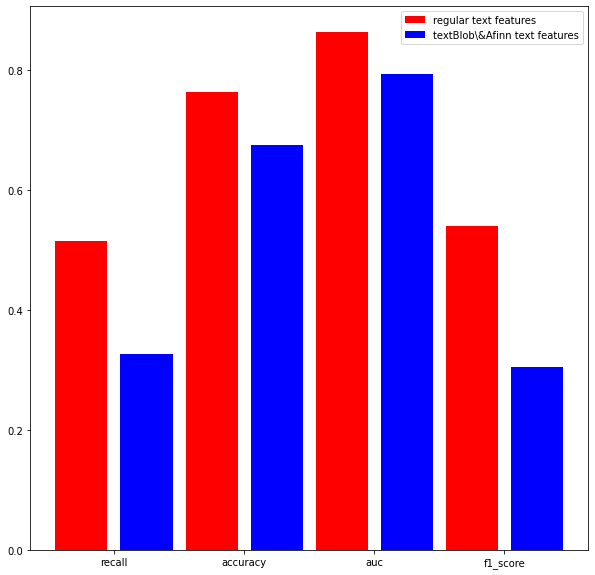

In [ ]:
# comparing the two classifiers
fig, ax = plt.subplots(figsize=(10,10))
# take the following score values from each evaluation dictionaries: 'recall' , 'accuracy', 'auc', 'f1_score'
scores_to_collect = ['recall' , 'accuracy', 'auc', 'f1_score']
cls_evalution_dictionaries_to_collect_from = [dict(cls_eval_results), dict(cls_with_sentiment_analysis_features_eval_results)]
regular_text_analysis_scores = []
text_blob_and_affin_scores = []
for score_to_collect in scores_to_collect:
  regular_text_analysis_scores.append(cls_evalution_dictionaries_to_collect_from[0][score_to_collect])
  text_blob_and_affin_scores.append(cls_evalution_dictionaries_to_collect_from[1][score_to_collect])

x_ticks = np.arange(0, len(scores_to_collect)*2, 2) 

ax.bar(x_ticks-0.5, regular_text_analysis_scores,color='red', label = 'regular text features')
ax.bar(x_ticks+0.5, text_blob_and_affin_scores,color='blue', label = 'textBlob\&Afinn text features')

ax.set_xticks(x_ticks)
ax.set_xticklabels(scores_to_collect)

ax.legend()
plt.show()

## Q3

**Question 3:**  Select a different reviews dataset and create a sentiment classifier which utilizes word embeddings (25pt).
Evaluate this classifier (5pt). Try to improve your classifier by adding additional features (20pt)

### Preperations:

In [5]:
# ! pip install turicreate
# ! pip install kaggle 
# ! pip install gensim
# ! pip install pyLDAvis
# ! pip install spaCy
# ! pip install afinn
# ! pip install textblob

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json 
! mkdir -f ./datasets/hotel_reviews

! kaggle datasets download anu0012/hotel-review  -p ./datasets/hotel_reviews
! unzip ./datasets/hotel_reviews/*.zip  -d ./datasets/hotel_reviews

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: invalid option -- 'f'
Try 'mkdir --help' for more information.
 41% 9.00M/21.7M [00:00<00:00, 24.0MB/s]
100% 21.7M/21.7M [00:00<00:00, 44.3MB/s]
Archive:  ./datasets/hotel_reviews/hotel-review.zip
  inflating: ./datasets/hotel_reviews/test.csv  
  inflating: ./datasets/hotel_reviews/train.csv  


In [1]:
# IMPORTS
import os
import json
import re
import requests
from typing import *
import numpy as np
import pandas as pd
import turicreate as turi
import networkx as ntkx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from textblob import TextBlob
from afinn import Afinn
import spacy


%matplotlib inline

In [2]:
#  i will use the hotel review dataset (only the training dataset)
hotels_reviews_sframe = turi.SFrame.read_csv("./datasets/hotel_reviews/train.csv", na_values=['none'])
hotels_reviews_sframe

Finished parsing file /content/datasets/hotel_reviews/train.csv

Parsing completed. Parsed 100 lines in 0.543543 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/datasets/hotel_reviews/train.csv

Parsing completed. Parsed 38932 lines in 0.520892 secs.

User_ID,Description,Browser_Used,Device_Used,Is_Response
id10326,The room was kind ofclean but had a VERY ...,Edge,Mobile,not happy
id10327,I stayed at the CrownPlaza April -- - April ...,Internet Explorer,Mobile,not happy
id10328,I booked this hotelthrough Hotwire at the ...,Mozilla,Tablet,not happy
id10329,Stayed here with husbandand sons on the way t ...,InternetExplorer,Desktop,happy
id10330,My girlfriends and Istayed here to celebrate ...,Edge,Tablet,not happy
id10331,We had - rooms. One wasvery nice and clearly ...,InternetExplorer,Desktop,happy
id10332,My husband and I havestayed in this hotel a ...,Firefox,Tablet,not happy
id10333,My wife & I stayed inthis glorious city a ...,Google Chrome,Mobile,happy
id10334,My boyfriend and I stayedat the Fairmont on a ...,Internet Explorer,Desktop,happy
id10335,"Wonderful staff, greatlocation, but it was ...",Chrome,Tablet,not happy


In [8]:
# i will use the spacy library to import a word->embedding dictionary 
!python -m spacy download en_core_web_lg # Important! you need to restart runtime after install
spacy_word_to_tokens = spacy.load('en_core_web_lg')


     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=e5cec03c0f55baf4115a91b867433833bc2faada3460ac8402cdcf5bfcec4cd3
  Stored in directory: /tmp/pip-ephem-wheel-cache-59sx8h7i/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


### Q3 ans:

In [ ]:
hotels_reviews_embeddings_sframe = turi.SFrame()

main_text_field = 'Description'
class_field = 'Is_Response'

l = []
for i in tqdm(range(len(hotels_reviews_sframe))):
    text = hotels_reviews_sframe[i][main_text_field]
    l.append(spacy_word_to_tokens(text).vector)


In [8]:
hotels_reviews_embeddings_sframe['word_embeddings'] = l 
hotels_reviews_embeddings_sframe['class'] = hotels_reviews_sframe[class_field]

# addings additional features:
hotels_reviews_embeddings_sframe['words_1grams'] = turi.text_analytics.count_ngrams(hotels_reviews_sframe[main_text_field], n=1, method='word')
hotels_reviews_embeddings_sframe['words_2grams'] = turi.text_analytics.count_ngrams(hotels_reviews_sframe[main_text_field], n=2, method='word')
# TextBlob features
hotels_reviews_embeddings_sframe['TextBlob text polarity'] = hotels_reviews_sframe[main_text_field].apply(lambda review: TextBlob(review).sentiment.polarity)
hotels_reviews_embeddings_sframe['TextBlob text subjectivity'] = hotels_reviews_sframe[main_text_field].apply(lambda review: TextBlob(review).sentiment.subjectivity)
# Afinn features
afinn = Afinn()
hotels_reviews_embeddings_sframe['Afinn text score'] = hotels_reviews_sframe[main_text_field].apply(lambda t: afinn.score(t))


features_list = ['word_embeddings', 'words_1grams', 'words_2grams', 'TextBlob text polarity', 'TextBlob text subjectivity', 'Afinn text score']

In [11]:
# training and evaluating the classifier with only word embeddings as features.
# splitting and training
train, test = hotels_reviews_embeddings_sframe.random_split(0.8)
cls_with_embeddings_only = turi.classifier.create(train, features=['word_embeddings'], target='class', verbose=True)
cls_with_additional_features = turi.classifier.create(train, features=features_list, target='class', verbose=True)
# evaluating the classifier
cls_with_embeddings_only_eval_results = cls_with_embeddings_only.evaluate(test)
cls_with_additional_features_eval_results = cls_with_additional_features.evaluate(test)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 29626

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 300

Number of coefficients      : 301

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 5.880037     | 0.870249          | 0.871795            |

| 2         | 3        | 9.002871     | 0.875751          | 0.876923            |

| 3         | 4        | 12.136589    | 0.877776          | 0.876282            |

| 4         | 5        | 15.287015    | 0.878789          | 0.879487            |

| 5         | 6        | 18.414950    | 0.879059          | 0.879487            |

| 6         | 7        | 21.541789    | 0.879093          | 0.879487            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

SVM:

--------------------------------------------------------

Number of examples          : 29626

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 300

Number of coefficients    : 301

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 5        | 0.050694  | 1.088533     | 0.679775          | 0.689744            |

| 1         | 9        | 1.064572  | 2.153764     | 0.681732          | 0.691026            |

| 2         | 10       | 1.064572  | 2.564931     | 0.324647          | 0.319872            |

Warning: Reached max step size.

| 3         | 19       | 25.000000 | 4.687748     | 0.683656          | 0.691667            |

| 4         | 20       | 25.000000 | 5.091477     | 0.717174          | 0.717949            |

| 9         | 32       | 1.000000  | 8.647509     | 0.840748          | 0.832051            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.8794871794871795
PROGRESS: SVMClassifier                   : 0.8320512820512821
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 29626

Number of classes           : 2

Number of feature columns   : 6

Number of unpacked features : 730018

Number of coefficients      : 730019

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 5        | 0.060853  | 2.445286     | 0.694019          | 0.700000            |

| 1         | 9        | 1.277915  | 4.471651     | 0.886249          | 0.780128            |

| 2         | 10       | 1.277915  | 5.225307     | 0.960069          | 0.847436            |

| 3         | 11       | 1.277915  | 5.983076     | 0.982482          | 0.867308            |

| 4         | 12       | 1.277915  | 6.742221     | 0.993620          | 0.874359            |

| 9         | 18       | 1.277915  | 11.015411    | 0.999899          | 0.878846            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 29626

Number of classes           : 2

Number of feature columns   : 6

Number of unpacked features : 730018

Number of coefficients    : 730019

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 6        | 0.024763  | 2.468125     | 0.694019          | 0.700000            |

| 1         | 11       | 2.104876  | 4.672555     | 0.944508          | 0.848718            |

| 2         | 12       | 2.104876  | 5.366888     | 0.970094          | 0.858974            |

| 3         | 13       | 2.104876  | 6.065292     | 0.994532          | 0.861538            |

| 4         | 14       | 2.104876  | 6.770929     | 0.996658          | 0.857051            |

| 9         | 20       | 2.088888  | 10.715144    | 0.999899          | 0.852564            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.8788461538461538
PROGRESS: SVMClassifier                   : 0.8525641025641025
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


As can be seen from the results, adding features to the embeddings XXXXXX

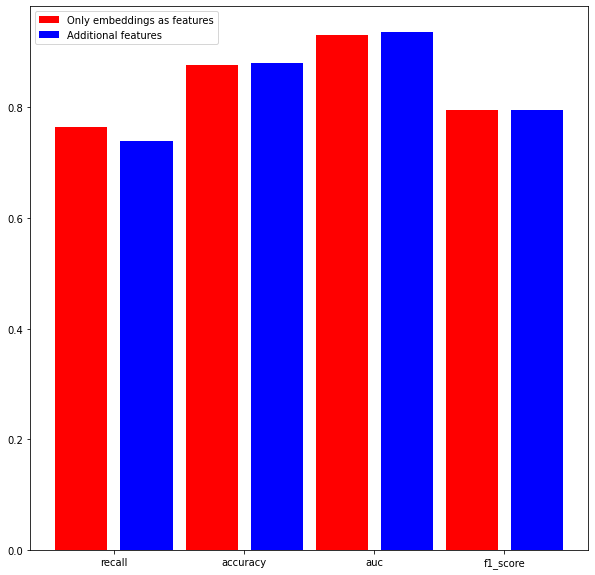

In [12]:
# comparing the two classifiers
fig, ax = plt.subplots(figsize=(10,10))
# take the following score values from each evaluation dictionaries: 'recall' , 'accuracy', 'auc', 'f1_score'
scores_to_collect = ['recall' , 'accuracy', 'auc', 'f1_score']
cls_evalution_dictionaries_to_collect_from = [dict(cls_with_embeddings_only_eval_results), dict(cls_with_additional_features_eval_results)]
regular_text_analysis_scores = []
text_blob_and_affin_scores = []
for score_to_collect in scores_to_collect:
  regular_text_analysis_scores.append(cls_evalution_dictionaries_to_collect_from[0][score_to_collect])
  text_blob_and_affin_scores.append(cls_evalution_dictionaries_to_collect_from[1][score_to_collect])

x_ticks = np.arange(0, len(scores_to_collect)*2, 2) 

ax.bar(x_ticks-0.5, regular_text_analysis_scores,color='red', label = 'Only embeddings as features')
ax.bar(x_ticks+0.5, text_blob_and_affin_scores,color='blue', label = 'Additional features')

ax.set_xticks(x_ticks)
ax.set_xticklabels(scores_to_collect)

ax.legend()
plt.show()